# Logistic Regression
## Intro
A logistic regression is a **classification algorithm which determines the binary output** (i.e. 0 or 1) of a desired dependent variable (y) given a combination of input feature variables (x).

In this example (link below to data and project), we will be looking at a set of banking data for individuals and use it to determine whether or not future customers (or those that have not subscribed yet) will subscribe.

A number of assumptions need to be met for a logistic regression to work effectively:
* Independent variables must be independent of each other (i.e. **no multicollinearity**).
* Dependent variable must be either a 0 or 1 (where 0 is negative outcome and 1 is positive).
* Logistic regression works far better on large datasets, therefore sample size must be reasonable.
* Only meaningful variables (features) should be included in the model.
* Independent variables must be linearly related to the log odds (clarify this).

**Project Link:** https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

## Investigation
Let's begin by loading our data and taking an initial look at it.

There are a 21 variables in our dataset and 41,188 samples, many of our variables are categorical with a number of values within them so we may need to do some cleaning/preparation.

The main thing to be aware of here is that the **duration** variable refers to the length of the previous call with each customer. Before a call is made, we don't know if the individual will be a 0 or 1 (i.e. will subscribe or not), whereas when the call has ended we will know for sure as they'll have given an answer during the call. This means that we should only use this variable for benchmarking and not in a true predictive model, because the length of the call and the fact it yields a result will fundamentally affect our outcome and introduce an unfair bias.

In [1]:
# load libraries
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns

# show plots in notebook
%matplotlib inline

# define plot characteristics
plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

# read in data
df = pd.read_csv('bank_data.csv', header=0)

# peek at data
print(df.shape)
print(list(df.columns))
df.head()

(41188, 21)
['age', 'job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,44,blue-collar,married,basic.4y,unknown,yes,no,cellular,aug,thu,...,1,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1,0
1,53,technician,married,unknown,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,0
2,28,management,single,university.degree,no,yes,no,cellular,jun,thu,...,3,6,2,success,-1.7,94.055,-39.8,0.729,4991.6,1
3,39,services,married,high.school,no,no,no,cellular,apr,fri,...,2,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0
4,55,retired,married,basic.4y,no,yes,no,cellular,aug,fri,...,1,3,1,success,-2.9,92.201,-31.4,0.869,5076.2,1


Firstly, our education variable contains a lot of values, let's condense this for ease going forwards by grouping together all basic education levels.

In [2]:
# check values before
print(df['education'].unique())

# group basic education together
df['education'] = np.where(df['education'] == 'basic.4y', "basic", df['education'])
df['education'] = np.where(df['education'] == 'basic.6y', "basic", df['education'])
df['education'] = np.where(df['education'] == 'basic.9y', "basic", df['education'])

# check values after
print(df['education'].unique())

['basic.4y' 'unknown' 'university.degree' 'high.school' 'basic.9y'
 'professional.course' 'basic.6y' 'illiterate']
['basic' 'unknown' 'university.degree' 'high.school' 'professional.course'
 'illiterate']


Let's take a look at our target (y) variable and see what it contains initially.

0    36548
1     4640
Name: y, dtype: int64


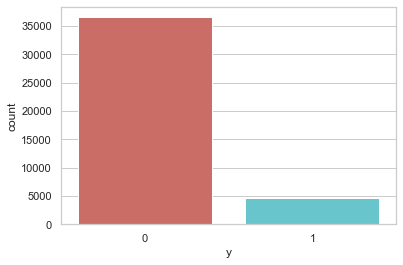

In [3]:
# count of binary values for target
print(df['y'].value_counts())

# plot as countplot
sns.countplot(x='y', data=df, palette='hls')

In [4]:
# calculate proportion of 0 and 1 in y
no_sub_count = len(df[df['y'] == 0])
sub_count = len(df[df['y'] == 1])
p_no_sub = no_sub_count / len(df['y'])
p_sub = sub_count / len(df['y'])

# show results
print('Subscriber count: ', sub_count, p_sub*100)
print('Non-subscriber count: ', no_sub_count, p_no_sub*100)

Subscriber count:  4640 11.265417111780131
Non-subscriber count:  36548 88.73458288821988


You can clearly see that the majority (almost 90%) of samples are not subscribers, this is quite a heavy imbalance in the target variable and we will need to do something to balance this out and identify what determines subscribers.

Before doing so, let's dig a little deeper into the data.

In [5]:
# show mean of numeric variables in relation to 0 and 1 of target variable
df.groupby('y').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed
y,,,,,,,,,,
0,39.911185,220.844807,2.633085,984.113878,0.132374,0.248875,93.603757,-40.593097,3.811491,5176.166600
1,40.913147,553.191164,2.051724,792.035560,0.492672,-1.233448,93.354386,-39.789784,2.123135,5095.115991


A few key findings from this analysis are:
* Average age for people subscribing is slightly higher than those not.
* Number of days since being contacted is less for people who have subscribed than not, this makes sense as the more recent the call, the more fresh in the memory and the better the chance of a sale.
* However, somewhat counter-intuitively, campaigns (the number of contacts in current campaign) are lower for successful subscriptions, perhaps indicating that people are less likely to buy if hassled or perhaps that if they're not going to initially, they may never.

Let's also look at mean values for some of our categorical variables, starting with job type.

In [6]:
df.groupby('job').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
job,,,,,,,,,,,
admin.,38.187296,254.312128,2.623489,954.319229,0.189023,0.015563,93.534054,-40.245433,3.550274,5164.125350,0.129726
blue-collar,39.555760,264.542360,2.558461,985.160363,0.122542,0.248995,93.656656,-41.375816,3.771996,5175.615150,0.068943
entrepreneur,41.723214,263.267857,2.535714,981.267170,0.138736,0.158723,93.605372,-41.283654,3.791120,5176.313530,0.085165
housemaid,45.500000,250.454717,2.639623,960.579245,0.137736,0.433396,93.676576,-39.495283,4.009645,5179.529623,0.100000
management,42.362859,257.058140,2.476060,962.647059,0.185021,-0.012688,93.522755,-40.489466,3.611316,5166.650513,0.112175
retired,62.027326,273.712209,2.476744,897.936047,0.327326,-0.698314,93.430786,-38.573081,2.770066,5122.262151,0.252326
self-employed,39.949331,264.142153,2.660802,976.621393,0.143561,0.094159,93.559982,-40.488107,3.689376,5170.674384,0.104856
services,37.926430,258.398085,2.587805,979.974049,0.154951,0.175359,93.634659,-41.290048,3.699187,5171.600126,0.081381
student,25.894857,283.683429,2.104000,840.217143,0.524571,-1.408000,93.331613,-40.187543,1.884224,5085.939086,0.314286


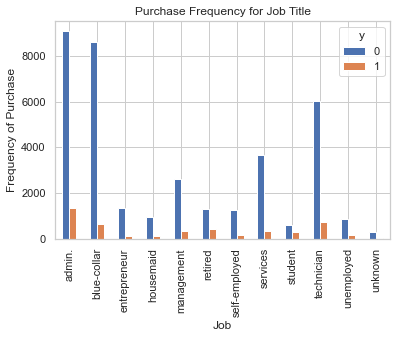

In [7]:
# build a bar chart of job type vs. target
pd.crosstab(df['job'],df['y']).plot(kind='bar')
plt.title('Purchase Frequency for Job Title')
plt.xlabel('Job')
plt.ylabel('Frequency of Purchase')
plt.savefig('purchase_fre_job')

Job type looks like a useful variable in determining sale success or not, there's a reasonable variation between both the 0s and 1s for our target variable and the sample sizes differ a fair amount too.

In [8]:
df.groupby('marital').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
marital,,,,,,,,,,,
divorced,44.899393,253.790330,2.61340,968.639853,0.168690,0.163985,93.606563,-40.707069,3.715603,5170.878643,0.103209
married,42.307165,257.438623,2.57281,967.247673,0.155608,0.183625,93.597367,-40.270659,3.745832,5171.848772,0.101573
single,33.158714,261.524378,2.53380,949.909578,0.211359,-0.167989,93.517300,-40.918698,3.317447,5155.199265,0.140041
unknown,40.275000,312.725000,3.18750,937.100000,0.275000,-0.221250,93.471250,-40.820000,3.313038,5157.393750,0.150000


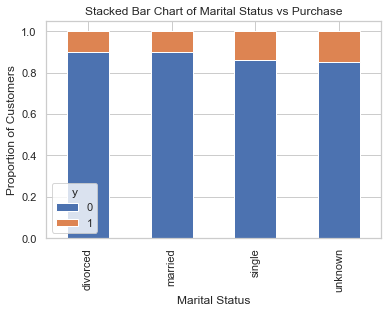

In [9]:
table=pd.crosstab(df['marital'],df['y'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Marital Status vs Purchase')
plt.xlabel('Marital Status')
plt.ylabel('Proportion of Customers')
plt.savefig('mariral_vs_pur_stack')

The marital status however does not appear to be a useful predictor, showing little variation between categories.

In [10]:
df.groupby('education').mean()

,age,duration,campaign,pdays,previous,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
education,,,,,,,,,,,
basic,42.163910,263.043874,2.559498,974.877967,0.141053,0.191329,93.639933,-40.927595,3.729654,5172.014113,0.087029
high.school,37.998213,260.886810,2.568576,964.358382,0.185917,0.032937,93.584857,-40.940641,3.556157,5164.994735,0.108355
illiterate,48.500000,276.777778,2.277778,943.833333,0.111111,-0.133333,93.317333,-39.950000,3.516556,5171.777778,0.222222
professional.course,40.080107,252.533855,2.586115,960.765974,0.163075,0.173012,93.569864,-40.124108,3.710457,5170.155979,0.113485
university.degree,38.879191,253.223373,2.563527,951.807692,0.192390,-0.028090,93.493466,-39.975805,3.529663,5163.226298,0.137245
unknown,43.481225,262.390526,2.596187,942.830734,0.226459,0.059099,93.658615,-39.877816,3.571098,5159.549509,0.145003


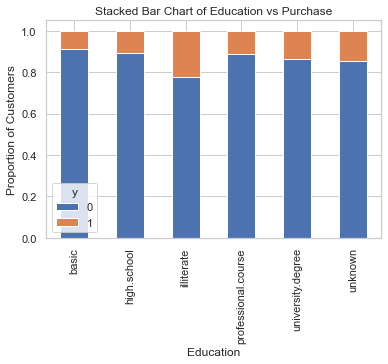

In [11]:
table=pd.crosstab(df['education'],df['y'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Stacked Bar Chart of Education vs Purchase')
plt.xlabel('Education')
plt.ylabel('Proportion of Customers')
plt.savefig('edu_vs_pur_stack')

Education shows a fairly interesting picture across each group so we can pick this out as a useful variable to look at too.

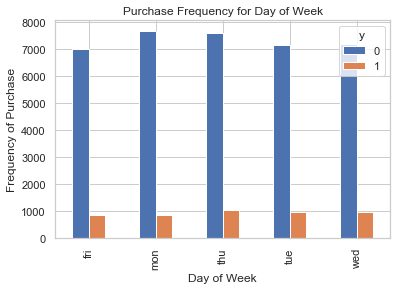

In [12]:
pd.crosstab(df['day_of_week'],df['y']).plot(kind='bar')
plt.title('Purchase Frequency for Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_dayofweek_bar')

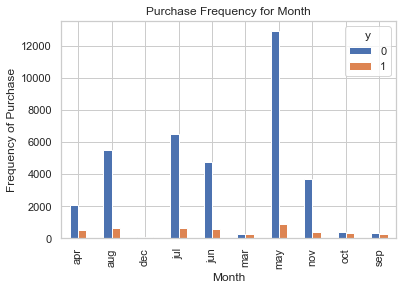

In [13]:
pd.crosstab(df['month'],df['y']).plot(kind='bar')
plt.title('Purchase Frequency for Month')
plt.xlabel('Month')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_month_bar')

Day of the week appears to give little insight into our target variable, whilst month does have some variance between success/failure month on month so could be a good one to look at too.

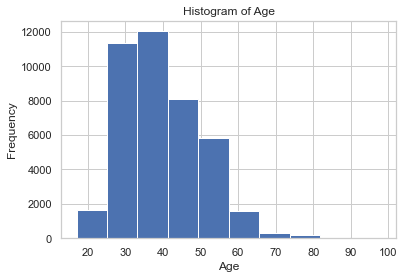

In [14]:
df['age'].hist()
plt.title('Histogram of Age')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.savefig('hist_age')

Our dataset seems to target 30-40 year olds primarily, might be worth consideration in the results.

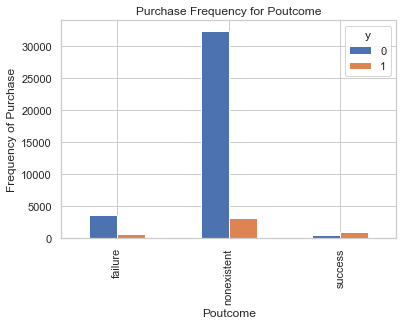

In [15]:
pd.crosstab(df['poutcome'],df['y']).plot(kind='bar')
plt.title('Purchase Frequency for Poutcome')
plt.xlabel('Poutcome')
plt.ylabel('Frequency of Purchase')
plt.savefig('pur_fre_pout_bar')

'Poutcome' is the result of the previous marketing campaign, this seems like it might be a useful one to look at. In particular, there appears to be a higher chance of success if the previous campaign was successful. Also, people who haven't been approached before are the main bucket of successes albeit with a much higher sample (and therefore lower proportion) than the other buckets.

## Categorical Encoding
There are a number of categorical variables in our dataset, therefore we will need to encode them as numbers by **creating dummy variables (i.e. OneHotEncoding)**.

In [16]:
# list categorical variables
cat_vars = ['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome']

# convert categorical vars into dummy vars
df_enc = pd.get_dummies(df)

# extract all col names
df_cols = df_enc.columns.values.tolist()

# drop categorical raw columns
keep_cols = [i for i in df_cols if i not in cat_vars]

# apply cols to keep numerical vars only
df_enc = df_enc[keep_cols]

# check final
df_enc.columns.values

array(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp_var_rate',
       'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug',
       'month_dec', 'month_jul', 'month_jun', 'month_mar', 'month_may',
       'month_nov', 'month_oct', 'month_sep', 'day_of_week_fri',

## SMOTE and Over-Sampling
We saw earlier that our target class variable contained a really uneven distribution of class values (~89% 0 class, ~11% 1 class) which means that our models are likely to ignore or significantly under-value the 1 class value which is the key value we're interested in.

As such, we will use SMOTE (Synthetic Minority Over-Sampling Technique) to over-sample our minority class and under-sample our majority class (we don't actually under-sample/reduce our majority class in this case, but you can do using libraries such as RandomUnderSampler).

This method works by identifying the k-nearest neighbours (often k=5) to data points in our desired target class (i.e. 1), drawing a line between our selected data point and a randomly selected neighbour from the 5 and then creating a data point along this line. This is repeated until we have created a desired threshold of target class values (often comparable to the majority class). This method therefore creates synthetic copies of our minority class which are non-identical to any existing points, this is preferable to simply duplicating existing values.

In [22]:
# split X and y variables out
X = df_enc.loc[:, df_enc.columns != 'y']
y = df_enc.loc[:, df_enc.columns == 'y']

# load libraries
from imblearn.over_sampling import SMOTE

# create over-sampling object
os = SMOTE(random_state=0)

# split train and test samples (70:30)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# identify columns
columns = X_train.columns

# over-sample training data
os_X_train, os_y_train = os.fit_sample(X_train, y_train)

# store X and y in df
os_X_train = pd.DataFrame(data = os_X_train, columns=columns)
os_y_train = pd.DataFrame(data = os_y_train, columns=['y'])

# check results
print("Length of oversampled data is ", len(os_X_train))
print("Number of no subscription in oversampled data", len(os_y_train[os_y_train['y']==0]))
print("Number of subscription", len(os_y_train[os_y_train['y']==1]))
print("Proportion of no subscription data in oversampled data is ", len(os_y_train[os_y_train['y']==0])/len(os_X_train))
print("Proportion of subscription data in oversampled data is ", len(os_y_train[os_y_train['y']==1])/len(os_X_train))

Length of oversampled data is  51134
Number of no subscription in oversampled data 25567
Number of subscription 25567
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


## Standardization
Our feature variable scales are drastically different from one another, particularly now that we have introduced dummy variables with binary values which contrast highly with the variance of our other feature variables. Therefore we will standardize our feature variables to have mean 0 and variance 1.

Feature scaling should be applied after splitting the data into train and test samples and it should only be build on the training data, this is to ensure that test data is fresh and unseen when it is used and only the training data has been used for any form of adjustments to the dataset.

**When to scale features:** https://datascience.stackexchange.com/questions/54908/data-normalization-before-or-after-train-test-split

In [50]:
# extract df columns
df_cols = df_enc.columns.values.tolist()

# extract features and target columns
y = ['y']
X_cols = [i for i in df_cols if i not in y]

# load libraries
from sklearn.preprocessing import StandardScaler

# standardize features (i.e. mean around 0, std of 1)
os_X_train_std = StandardScaler().fit_transform(os_X_train) # apply to training data only

# convert to df
os_X_train_std = pd.DataFrame(data=os_X_train_std, columns=X_cols)

It's clear that the split of class 0 and class 1 (i.e. no subscription and subscription) in our dataset is now exactly even and this will allow us to move forward with our model.

**NOTE:** we only performed over-sampling on the training data, this is to ensure that we created no synthetic information in our test data which could/would have resulted in bleeding learnings into our test data and introducing bias into the results.

## Recursive Feature Elimination (RFE)
We have an awful lot of features in our dataset, particularly now that we've created dummy variables for every possible combination of categorical feature in our dataset. Therefore we will now keep only the most significant/relevant features to our target variable by recursively removing features that negatively or non-significantly affect our logistic regression model.

**Logistic Regression Docs:** https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

**RFE Notes:** https://machinelearningmastery.com/rfe-feature-selection-in-python/

In [52]:
# load libraries
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# create model object
logreg = LogisticRegression()

# build RFE
rfe = RFE(logreg, 20) # select 20 features
rfe_model = rfe.fit(os_X_train_std, os_y_train.values.ravel())
print(rfe_model.ranking_)
print(rfe_model.support_)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass n_features_to_select=20 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or sca

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

[42  1 38 12 40  1  6 36 28 35 17 13 19 20 18 21 15 14 23 16 22 24  9  7
  8 30  1  2 39  4  3  5  1  1 41  1 10  1  1  1  1  1  1 27 32 34 29 26
 37 11 25 31 33  1  1  1  1  1  1  1  1]
[False  True False False False  True False False False False False False
 False False False False False False False False False False False False
 False False  True False False False False False  True  True False  True
 False  True  True  True  True  True  True False False False False False
 False False False False False  True  True  True  True  True  True  True
  True]


We now have the selected optimum variables as show from our RFE process, we can build and run a logistic regression using these selected features and have an initial look at the outputs.

In [53]:
# cols selected from our RFE
cols=['euribor3m', 'job_blue-collar', 'job_housemaid', 'marital_unknown', 'education_illiterate', 'default_no', 'default_unknown', 
      'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 
      'month_may', 'month_nov', 'month_oct', "poutcome_failure", "poutcome_success"]

# extract X and y
X = os_X_train_std[cols]
y = os_y_train['y']

# load libraries
import statsmodels.api as sm

# check implementation of current model
logit_model = sm.Logit(y,X) # instantiate model (sigmoid or logistic function)
result = logit_model.fit() # fit model using X and y
print(result.summary2()) # check outputs

Optimization terminated successfully.
         Current function value: 0.339792
         Iterations 7
                           Results: Logit
Model:                Logit             Pseudo R-squared:  0.510     
Dependent Variable:   y                 AIC:               34789.8396
Date:                 2020-08-21 10:42  BIC:               34966.6837
No. Observations:     51134             Log-Likelihood:    -17375.   
Df Model:             19                LL-Null:           -35443.   
Df Residuals:         51114             LLR p-value:       0.0000    
Converged:            1.0000            Scale:             1.0000    
No. Iterations:       7.0000                                         
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
euribor3m            -0.8241   0.0203 -40.5047 0.0000 -0.8640 -0.7843
job_blue-collar 

If we look at the p-value column, all variables have <5% except for two, therefore we shall remove these two variables as well from our dataset and re-run the analysis.

In [54]:
# cols selected from our RFE
cols=['euribor3m', 'job_blue-collar', 'job_housemaid', 'default_no', 'default_unknown', 
      'contact_cellular', 'contact_telephone', 'month_apr', 'month_aug', 'month_dec', 'month_jul', 'month_jun', 'month_mar', 
      'month_may', 'month_nov', 'month_oct', "poutcome_failure", "poutcome_success"]

# extract X and y
X = os_X_train_std[cols]
y = os_y_train['y']

# check implementation of current model
logit_model = sm.Logit(y,X) # instantiate model
result = logit_model.fit() # fit model
print(result.summary2()) # check outputs

Optimization terminated successfully.
         Current function value: 0.339820
         Iterations 7
                          Results: Logit
Model:               Logit            Pseudo R-squared: 0.510     
Dependent Variable:  y                AIC:              34788.7357
Date:                2020-08-21 10:44 BIC:              34947.8954
No. Observations:    51134            Log-Likelihood:   -17376.   
Df Model:            17               LL-Null:          -35443.   
Df Residuals:        51116            LLR p-value:      0.0000    
Converged:           1.0000           Scale:            1.0000    
No. Iterations:      7.0000                                       
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
euribor3m         -0.8246   0.0203 -40.5331 0.0000 -0.8645 -0.7847
job_blue-collar   -0.4364   0.0174 -25.1221 0.0000 -0